In [1]:
import os
import sys
import babeltrace
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from IPython.display import display, clear_output

sys.path.append("/home/adlink/ros2-workspace/install/tracetools_read/lib/python3.8/site-packages/")
sys.path.append("/home/adlink/ros2-workspace/src/tracetools_analysis/tracetools_analysis/")
from tracetools_read.trace import *
from tracetools_analysis.loading import load_file
from tracetools_analysis.processor.ros2 import Ros2Handler
from tracetools_analysis.utils.ros2 import Ros2DataModelUtil

from dataclasses import dataclass
from typing import List, Dict, Set, Union, Tuple
from functools import cached_property
import pickle
import re

from utils import ProgressPrinter

In [2]:
def pkl_filename_from_file_timestamp(file_path):
    if os.path.exists(file_path):
        timestamp = os.path.getmtime(file_path)
        pkl_filename = f"ros_objects_{hash(timestamp)}.pkl"
        return pkl_filename, os.path.exists(pkl_filename)
    return None, False

path = os.path.expanduser("~/.ros/tracing/autoware-trace/")
path_converted = os.path.join(path, 'converted')
pkl_filename, pkl_exists = pkl_filename_from_file_timestamp(path_converted)

if not pkl_exists:
    file = load_file(path)
    handler = Ros2Handler.process(file)
    util = Ros2DataModelUtil(handler)
    pkl_filename, pkl_exists = pkl_filename_from_file_timestamp(path_converted)

found converted file: /home/adlink/.ros/tracing/autoware-trace/converted
 [100%] [Ros2Handler]


In [3]:
if False:
    n=1
    self = handler.data
    print('====================ROS 2 DATA MODEL===================')
    print('██ Contexts: ██')
    print(self.contexts[:n].to_string())
    print('██ Nodes: ██')
    print(self.nodes[:n].to_string())
    print('██ Publishers (rmw): ██')
    print(self.rmw_publishers[:n].to_string())
    print('██ Publishers (rcl): ██')
    print(self.rcl_publishers[:n].to_string())
    print('██ Subscriptions (rmw): ██')
    print(self.rmw_subscriptions[:n].to_string())
    print('██ Subscriptions (rcl): ██')
    print(self.rcl_subscriptions[:n].to_string())
    print('██ Subscription objects: ██')
    print(self.subscription_objects[:n].to_string())
    print('██ Services: ██')
    print(self.services[:n].to_string())
    print('██ Clients: ██')
    print(self.clients[:n].to_string())
    print('██ Timers: ██')
    print(self.timers[:n].to_string())
    print('██ Timer-node links: ██')
    print(self.timer_node_links[:n].to_string())
    print('██ Callback objects: ██')
    print(self.callback_objects[:n].to_string())
    print('██ Callback symbols: ██')
    print(self.callback_symbols[:n].to_string())
    print('██ Callback instances: ██')
    print(self.callback_instances[:n].to_string())
    print('██ Publish instances (rclcpp): ██')
    print(self.rclcpp_publish_instances[:n].to_string())
    print('██ Publish instances (rcl): ██')
    print(self.rcl_publish_instances[:n].to_string())
    print('██ Publish instances (rmw): ██')
    print(self.rmw_publish_instances[:n].to_string())
    print('██ Take instances (rmw): ██')
    print(self.rmw_take_instances[:n].to_string())
    print('██ Take instances (rcl): ██')
    print(self.rcl_take_instances[:n].to_string())
    print('██ Take instances (rclcpp): ██')
    print(self.rclcpp_take_instances[:n].to_string())
    print('██ Lifecycle state machines: ██')
    print(self.lifecycle_state_machines[:n].to_string())
    print('██ Lifecycle transitions: ██')
    print(self.lifecycle_transitions[:n].to_string())
    print('==================================================')

# Data Structures

In [4]:
def str_to_cls(classname):
    return getattr(sys.modules[__name__], classname)

def row_to_type(row, type, has_idx):
    return type(id=row.name, **row) if has_idx else type(**row)

def df_to_type_list(df, type):
    if isinstance(type, str):
        type = str_to_cls(type)
        
    has_idx = not isinstance(df.index, pd.RangeIndex)
    return [row_to_type(row, type, has_idx) for _, row in df.iterrows()]

def by_index(df, index, type):
    return df_to_type_list(df.loc[index], type)

def by_column(df, column_name, column_val, type):
    return df_to_type_list(df[df[column_name] == column_val], type)

def list_to_dict(ls, key='id'):
    return {getattr(item, key): item for item in ls}

#################################
# Predefined (from ROS2DataModel)
#################################

@dataclass
class Node:
    id: int
    timestamp: int
    tid: int
    rmw_handle: int
    name: str
    namespace: str

    @cached_property
    def path(self) -> str:
        return os.path.join(self.namespace, self.name)

    @cached_property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.node_handle == self.id, publishers.values()))

    @cached_property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.node_handle == self.id, subscriptions.values()))
    
    @cached_property
    def timers(self) -> List['Timer']:
        links = [link.id for link in timer_node_links.values() if link.node_handle == self.id]
        return list(filter(lambda timer: timer.id in links, timers.values()))

    def __hash__(self):
        return hash(self.id)

@dataclass
class Publisher:
    id: int
    timestamp: int
    node_handle: int
    rmw_handle: int
    topic_name: str
    depth: int

    @property
    def node(self) -> 'Node':
        return nodes[self.node_handle]

    @cached_property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.topic_name == self.topic_name, subscriptions.values()))

    @cached_property
    def instances(self) -> List['PublishInstance']:
        return list(filter(lambda inst: inst.publisher_handle == self.id, publish_instances))
    
    @property
    def topic(self) -> 'Topic':
        return topics[self.topic_name]

    def __hash__(self):
        return hash(self.id)


@dataclass
class Subscription:
    id: int
    timestamp: int
    node_handle: int
    rmw_handle: int
    topic_name: str
    depth: int

    @property
    def node(self) -> 'Node':
        return nodes[self.node_handle]

    @cached_property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.topic_name == self.topic_name, publishers.values()))
    
    @cached_property
    def subscription_object(self) -> 'SubscriptionObject':
        sub_objs = list(filter(lambda sub_obj: sub_obj.subscription_handle == self.id, subscription_objects.values()))
        assert len(sub_objs) <= 1
        return sub_objs[0] if sub_objs else None

    @property
    def topic(self) -> 'Topic':
        return topics[self.topic_name]

    def __hash__(self):
        return hash(self.id)
    
@dataclass
class Timer:
    id: int
    timestamp: int
    period: int
    tid: int

    @cached_property
    def nodes(self) -> List['Node']:
        links = [link.node_handle for link in timer_node_links.values() if link.id == self.id]
        return list(filter(lambda node: node.id in links, nodes.values()))
    
    @property
    def callback_object(self) -> 'CallbackObject':
        return callback_objects[self.id]

    def __hash__(self):
        return hash(self.id)

@dataclass
class TimerNodeLink:
    id: int
    timestamp: int
    node_handle: int

@dataclass
class SubscriptionObject:
    id: int             # subscription
    timestamp: int
    subscription_handle: int

    @property
    def subscription(self) -> 'Subscription':
        return subscriptions[self.subscription_handle]

    @property
    def callback_object(self) -> 'CallbackObject':
        return callback_objects[self.id]

    def __hash__(self):
        return hash((self.id, self.timestamp, self.subscription_handle))

@dataclass
class CallbackObject:
    id: int             # (reference) = subscription_object.id | timer.id | ....
    timestamp: int
    callback_object: int

    @cached_property
    def callback_instances(self) -> List['CallbackInstance']:
        return list(filter(lambda inst: inst.callback_object == self.callback_object, callback_instances))

    @cached_property
    def owner(self):
        if self.id in timers:
            return timers[self.id]
        if self.id in publishers:
            return publishers[self.id]
        if self.id in subscription_objects:
            return subscription_objects[self.id]
        if self.id in handler.data.services.index:
            return 'Service'
        if self.id in handler.data.clients.index:
            return 'Client'
        return None

    @cached_property
    def owner_info(self):
        info = util.get_callback_owner_info(self.callback_object)
        if info is None:
            return None, None
        
        type_name, dict_str = info.split(" -- ")
        kv_strs = dict_str.split(", ")
        info_dict = {k: v for k, v in map(lambda kv_str: kv_str.split(": ", maxsplit=1), kv_strs)}
        return type_name, info_dict

    def __hash__(self):
        return hash((self.id, self.timestamp, self.callback_object))

@dataclass
class PublishInstance:
    publisher_handle: int
    timestamp: int
    message: int

    @property
    def publisher(self) -> 'Publisher':
        return publishers[self.publisher_handle]

    def __hash__(self):
        return hash((self.publisher_handle, self.timestamp, self.message))

@dataclass
class CallbackInstance:
    callback_object: int
    timestamp: pd.Timestamp
    duration: pd.Timedelta
    intra_process: bool

    @property
    def callback_obj(self) -> 'CallbackObject':
        return callback_objects[self.callback_object]

    def __hash__(self):
        return hash((self.callback_object, self.timestamp, self.duration))

@dataclass
class CallbackSymbol:
    id: int  # callback_object
    timestamp: int
    symbol: str

    @cached_property
    def callback_obj(self) -> 'CallbackObject':
        cb_objs = list(filter(lambda cb_obj: cb_obj.callback_object == self.id, callback_objects.values()))
        assert len(cb_objs) <= 1
        return cb_objs[0] if cb_objs else None

    def __hash__(self):
        return hash((self.id, self.timestamp, self.symbol))


#######################################
# Self-defined (not from ROS2DataModel)
#######################################

@dataclass
class Topic:
    name: str

    @cached_property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.topic_name == self.name, publishers.values()))
    
    @cached_property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.topic_name == self.name, subscriptions.values()))

    def __hash__(self):
        return hash(self.name)


In [5]:

if not pkl_exists:
    print("Did not find pickled ROS objects, extracting...")
    #######################################
    # Instantiate collections
    #######################################

    nodes:                  Dict[int, 'Node']               = list_to_dict(df_to_type_list(handler.data.nodes,                  'Node'));               print(f"Processed {len(nodes):<8d} nodes")
    publishers:             Dict[int, 'Publisher']          = list_to_dict(df_to_type_list(handler.data.rcl_publishers,         'Publisher'));          print(f"Processed {len(publishers):<8d} publishers")
    subscriptions:          Dict[int, 'Subscription']       = list_to_dict(df_to_type_list(handler.data.rcl_subscriptions,      'Subscription'));       print(f"Processed {len(subscriptions):<8d} subscriptions")
    timers:                 Dict[int, 'Timer']              = list_to_dict(df_to_type_list(handler.data.timers,                 'Timer'));              print(f"Processed {len(timers):<8d} timers")
    timer_node_links:       Dict[int, 'TimerNodeLink']      = list_to_dict(df_to_type_list(handler.data.timer_node_links,       'TimerNodeLink'));      print(f"Processed {len(timer_node_links):<8d} timer-node links")
    subscription_objects:   Dict[int, 'SubscriptionObject'] = list_to_dict(df_to_type_list(handler.data.subscription_objects,   'SubscriptionObject')); print(f"Processed {len(subscription_objects):<8d} subscription objects")
    callback_objects:       Dict[int, 'CallbackObject']     = list_to_dict(df_to_type_list(handler.data.callback_objects,       'CallbackObject'));     print(f"Processed {len(callback_objects):<8d} callback objects")
    callback_symbols:       Dict[int, 'CallbackSymbol']     = list_to_dict(df_to_type_list(handler.data.callback_symbols,       'CallbackSymbol'));     print(f"Processed {len(callback_symbols):<8d} callback symbols")
    publish_instances:      List['PublishInstance']         =              df_to_type_list(handler.data.rcl_publish_instances,  'PublishInstance');     print(f"Processed {len(publish_instances):<8d} publish instances")
    callback_instances:     List['CallbackInstance']        =              df_to_type_list(handler.data.callback_instances,     'CallbackInstance');    print(f"Processed {len(callback_instances):<8d} callback instances")

    _unique_topic_names = {*(pub.topic_name for pub in publishers.values()), *(sub.topic_name for sub in subscriptions.values())}
    topics: Dict[str, 'Topic'] = list_to_dict(map(Topic, _unique_topic_names), key="name"); print(f"Processed {len(topics):<8d} topics")

    print("Caching dynamic properties...")

    [(o.path, o.publishers, o.subscriptions, o.timers) for o in nodes.values()]         ; print("Cached node properties")
    [(o.instances, o.subscriptions) for o in publishers.values()]                       ; print("Cached publisher properties")
    [(o.publishers, o.subscription_object) for o in subscriptions.values()]             ; print("Cached subscription properties")
    [(o.nodes) for o in timers.values()]                                                ; print("Cached timer properties")
    [(o.callback_instances, o.owner, o.owner_info) for o in callback_objects.values()]  ; print("Cached callback object properties")
    [(o.callback_obj) for o in callback_symbols.values()]                               ; print("Cached callback symbol properties")
    [(o.publishers, o.subscriptions) for o in topics.values()]                          ; print("Cached topic properties")

    fields_to_pickle = [
        "nodes",
        "publishers",
        "subscriptions",
        "timers",
        "timer_node_links",
        "subscription_objects",
        "callback_objects",
        "callback_symbols",
        "publish_instances",
        "callback_instances",
        "topics"
    ]

    pkl_dict = {key: globals()[key] for key in fields_to_pickle}

    print("Pickling...")
    with open(pkl_filename, "wb") as f:
        pickle.dump(pkl_dict, f)
else:
    print("Found pickled ROS objects from previous session, restoring...")
    with open(pkl_filename, "rb") as f:
        pkl_dict = pickle.load(f)
        for k, v in pkl_dict.items():
            globals()[k] = v

print("Done.")


Did not find pickled ROS objects, extracting...
Processed 61       nodes
Processed 264      publishers
Processed 212      subscriptions
Processed 67       timers
Processed 31       timer-node links
Processed 201      subscription objects
Processed 483      callback objects
Processed 483      callback symbols
Processed 183512   publish instances
Processed 390810   callback instances
Processed 161      topics
Caching dynamic properties...
Cached node properties
Cached publisher properties
Cached subscription properties
Cached timer properties
Cached callback object properties
Cached callback symbol properties
Cached topic properties
Pickling...
Done.


# Callback-Sub & Callback-Timer Links

In [6]:
import re

sym_table = []

for sym in callback_symbols.values():
    try:
        cbo = list(filter(lambda val: val.callback_object==sym.id, callback_objects.values()))
        assert len(cbo) == 1
        cbo = cbo[0]
    except:
        print(len(cbo))
        continue
    owner_info = cbo.owner_info

    if None in owner_info: continue
    type, info = owner_info
    sym_table.append((sym, type, info))

sym_table.sort(key=lambda tup: tup[1])

def trim(string, length):
    if len(string) > length:
        return f"{string[:length-3]}..."
    return string

for sym, type, info in sym_table:
    sym: CallbackSymbol
    pretty_sym = util._prettify(sym.symbol)
    pretty_sym = re.sub(r"std::shared_ptr<(.*?)>", r"\1*", pretty_sym)
    try:
        i = len(sym.callback_obj.callback_instances)
    except KeyError:
        i = -1
    print(f"{trim(pretty_sym, 100):100s}: i={i:>4d} {type:12s} n={info['node']:40s}", end=' ') 
    if type == 'Timer':
        print(f"p={info['period']:7s}")
    elif type == 'Subscription':
        print(f"t={info['topic']:30s}")
    else:
        print()

NameError: name 'util' is not defined

# Topic-Node Mapping

In [5]:
# Aggregate topics that have the same pubs and subs
topic_cohorts = {}
for topic in topics.values():
    key = (frozenset({*(pub.node_handle for pub in topic.publishers)}), frozenset({*(sub.node_handle for sub in topic.subscriptions)}))
    if key not in topic_cohorts:
        topic_cohorts[key] = []
    topic_cohorts[key].append(topic)

print(f"{len(topics)} topics were aggregated into {len(topic_cohorts)} cohorts")

161 topics were aggregated into 78 cohorts


# Timer-Node Mapping

In [6]:
unknowns = {}

print_node_timer = lambda node_path, period: print(f"{node_path:<90s}: {1/(period*1e-9):8.2f}Hz")

for timer in timers.values():
    timer_nodes = timer.nodes
    if not timer_nodes:
        if timer.period not in unknowns:
            unknowns[timer.period] = 0
        unknowns[timer.period] += 1

    for node in timer_nodes: print_node_timer(node.path, timer.period)
        
for period, count in unknowns.items():
    print_node_timer(f"UNKNOWN (x{count})", period)

n_unknown = sum(unknowns.values())  # Values are counts per period
print(f"Found {len(timers) - n_unknown} timers with a recorded node, {n_unknown} without.")

/system/system_error_monitor                                                              :    10.00Hz
/system/emergency_handler                                                                 :    10.00Hz
/system/ad_service_state_monitor                                                          :     1.00Hz
/planning/scenario_planning/scenario_selector                                             :    10.00Hz
/planning/planning_diagnostics/planning_error_monitor                                     :     1.00Hz
/planning/planning_diagnostics/planning_error_monitor                                     :    10.00Hz
/system/system_monitor/cpu_monitor                                                        :     1.00Hz
/system/system_monitor/hdd_monitor                                                        :     1.00Hz
/control/trajectory_follower/lateral_controller_node_exe                                  :    33.33Hz
/system/system_monitor/hdd_monitor                                       

# Measure Frequency Deviations

In [7]:
# Get Publisher frequencies
df_publications = handler.data.rcl_publish_instances
pub_stats = {}
unknown = 0
for pi in publish_instances:
    try:
        pub = pi.publisher
    except KeyError:
        unknown += 1
        continue
    if pub.id not in pub_stats:
        pub_stats[pub.id] = {'times': []}
    pub_stats[pub.id]['times'].append(pi.timestamp*1e-9) # Nanoseconds to seconds float

print(f"{unknown} unknown publisher handles ({len(pub_stats)} known ones)")

219 unknown publisher handles (176 known ones)


# Plot Frequency Deviations

In [ ]:
fig_dirname = "fig_frequency"
os.makedirs(fig_dirname, exist_ok=True)
for i, (k, v) in enumerate(sorted(pub_stats.items(), key=lambda kv: len(kv[1]['times']), reverse=True)):
    pub_time_diff = np.diff(np.array(v['times']))
    v['period'] = pub_time_diff.mean()
    v['period_std'] = pub_time_diff.std()
    v['frequency'] = 1 / v['period']
    v['frequency_std'] = (1/pub_time_diff).std()

    try:
        publisher = publishers[k]
        publisher_node = publisher.node
        topic_name = publisher.topic_name
        node_path = publisher_node.path
    except Exception:
        topic_name="UNKNOWN"
        node_path="UNKNOWN"
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax.hist(1/pub_time_diff)
    ax.set_xlabel("Publication Frequency [Hz]")
    ax.set_ylabel("#Publications")
    ax.set_title(f"{node_path} =({v['frequency']:.2f}Hz)=> {topic_name}")
    plt.savefig(os.path.join(fig_dirname, f"{i:06}{node_path}__{topic_name}".replace('/','-')))


# Data Flow Graph

In [ ]:
node_filters = ["transform_listener_impl", "_monitor"]
topic_filters = ["/rosout", "/parameter_events", "/diagnostics"]

from pyvis.network import Network
net = Network(notebook=True, height='750px', width='100%', bgcolor='#ffffff', font_color='#000000')

net.add_node("INPUT", label="Input", size=100, color="green", physics=False, x=0, y=0)
net.add_node("OUTPUT", label="Output", size=100, color="red", physics=False, x=6000, y=0)


for node in nodes.values():
    if any(f in node.path for f in node_filters): 
        continue
    net.add_node(node.id, label=node.name, title=node.path, size=20, color="#333")

for cohort_key, cohort_topics in topic_cohorts.items():
    cohort_topic_names = [topic.name for topic in cohort_topics if not any(f in topic.name for f in topic_filters)]
    if not cohort_topic_names: 
        continue
    cohort_id="\n".join(cohort_topic_names)
    cohort_weight=len(cohort_topic_names)
    net.add_node(cohort_id, label=" ", title=cohort_id, size=5, color="#333")
    
    pubs = cohort_key[0]
    subs = cohort_key[1]
    n_pubs = len(pubs)
    n_subs = len(subs)
    
    try:
        if not n_pubs:
            net.add_edge("INPUT", cohort_id, arrows="to", color="green", weight=cohort_weight)
        if not n_subs:
            net.add_edge(cohort_id, "OUTPUT", arrows="to", color="red", weight=cohort_weight)

        for pub in pubs:
            net.add_edge(pub, cohort_id, arrows="to", color="green", weight=cohort_weight)
        for sub in subs:
            net.add_edge(cohort_id, sub, arrows="to", color="red", weight=cohort_weight)
    except:
        continue

net.toggle_physics(True)
net.show_buttons()
net.show("graph.html")

# Pub-Use Latencies
Compute for each node and its data dependencies the list of pub-use delays (per-topic-per-node list of pub-use delays)

In [6]:
def filter_none(ls):
    return filter(lambda x: x is not None, ls)

def safe_map(func, ls):
    def safe_func(arg):
        try:
            return func(arg)
        except:
            return None
    
    return map(safe_func, ls)

pub_use_delays = {node.id: {
    'pubs': {}, 
    'invocations': {}, 
    'n_unknown_invocations': 0, 
    'n_pub_timestamps': 0
    } for node in nodes.values()}

for node in nodes.values():
    node_pub_use_dict = pub_use_delays[node.id]
    timestamp_min = np.inf; timestamp_max = 0

    n_pub_timestamps = 0
    for sub in node.subscriptions:
        node_pub_use_dict['pubs'][sub.topic_name] = {}
        for pub in sub.publishers:
            pub_timestamps = [inst.timestamp for inst in pub.instances]

            try:
                pub_t_min = min(pub_timestamps); pub_t_max = max(pub_timestamps)
            except ValueError:
                pub_t_min = np.inf; pub_t_max = 0
            
            if pub_t_min < timestamp_min: timestamp_min = pub_t_min
            if pub_t_max > timestamp_max: timestamp_max = pub_t_max

            node_pub_use_dict['pubs'][sub.topic_name][pub.node.path] = pub_timestamps
            node_pub_use_dict['n_pub_timestamps'] += len(pub_timestamps)

    timer_cb_objs = list(filter_none(safe_map(lambda timer: timer.callback_object, node.timers)))
    subsc_cb_objs = list(filter_none(safe_map(lambda subsc: subsc.subscription_object.callback_object, node.subscriptions)))

    print(f"{node.path:95s} has {len(timer_cb_objs):1d} timer callbacks, {len(subsc_cb_objs):2d} subscription callbacks, {len(node_pub_use_dict['pubs']):2d} subscribed topics.")

    node_invocations = node_pub_use_dict['invocations']

    for cb_obj in timer_cb_objs + subsc_cb_objs:
        cb_invocations = []
        for inst in cb_obj.callback_instances:
            cb_invocations.append((inst.timestamp, inst.duration))

        node_invocations[cb_obj.id] = cb_invocations

/launch_ros_9807                                                                                has 0 timer callbacks,  0 subscription callbacks,  0 subscribed topics.
/system/system_monitor/system_monitor/system_monitor_container                                  has 0 timer callbacks,  1 subscription callbacks,  1 subscribed topics.
/robot_state_publisher                                                                          has 0 timer callbacks,  2 subscription callbacks,  2 subscribed topics.
/system/system_error_monitor                                                                    has 1 timer callbacks,  5 subscription callbacks,  5 subscribed topics.
/aggregator_node                                                                                has 1 timer callbacks,  2 subscription callbacks,  2 subscribed topics.
/system/emergency_handler                                                                       has 1 timer callbacks,  6 subscription callbacks,  5 subscribed 

In [ ]:
from matplotlib import cm

fig_dirname = "fig_pub_use"
os.makedirs(fig_dirname, exist_ok=True)
plt.close('all')

node_filters=[]#"transform_listener_impl",]

nodes_filtered = [node for node in nodes.values() if not any(f in node.path for f in node_filters)]
print(f"Ignoring {len(nodes.values()) - len(nodes_filtered)} nodes due to filters.")

common_offset = min(map(lambda cb_inst: cb_inst.timestamp.timestamp(), callback_instances))

zero_color = cm.get_cmap('viridis')(0.0)

for node_i, (node, node_path, node_pub_use_dict) in enumerate(map(lambda node: (node, node.path, pub_use_delays[node.id]), nodes_filtered)):

    if not node_pub_use_dict['invocations']:
        print(f"{node_path:95s} has no invocations, skipping.")
        continue

    if len(node_pub_use_dict['pubs']) == 0:
        print(f"Skipping {node_path}, no publications")
        continue

    fig = plt.figure(figsize=(15,5))
    ax: plt.Axes = fig.add_subplot()

    max_pubs_per_topic = max(len(pubs) for pubs in node_pub_use_dict['pubs'].values())
    topic_names, topic_pubs = (zip(*node_pub_use_dict['pubs'].items()))

    vmin = 0; vmax = max_pubs_per_topic

    y_labels = []
    current_y = 0

    for invoc_i, (cb_obj_id, cb_invocations) in enumerate(node_pub_use_dict['invocations'].items()):
        try:
            cb_obj = callback_objects[cb_obj_id]
            sym = callback_symbols[cb_obj.callback_object].symbol
            sym = Ros2DataModelUtil._prettify(None, sym)
            sym = re.sub(r"std::shared_ptr<(.*?)>", r"\1*", sym)

            cb_owner = cb_obj.owner
            if isinstance(cb_owner, Timer):
                cb_type = "T"
            elif isinstance(cb_owner, SubscriptionObject):
                cb_type = "S"
        except KeyError or AttributeError:
            sym = "UNKNOWN"
            cb_type = "U"
        
        y_labels.append(f"{sym} {cb_type}")
        n_markers = len(cb_invocations)

        points_x = []; points_y = []
        for time, dur in cb_invocations:
            time = time.timestamp() - common_offset; dur = dur.total_seconds()
            points_x += [time, time+dur, None]
            points_y += [current_y, current_y, 0.0]
        
        ax.plot(points_x,points_y, marker='.', c=zero_color)
        current_y += 1

    n_cbs = current_y

    for topic_i, (topic_name, pubs) in enumerate(zip(topic_names, topic_pubs)):
        for pub_i, (pub_name, timestamps) in enumerate(pubs.items()):
            n_markers = len(timestamps)
            ax.scatter(np.array(timestamps)*1e-9 - common_offset, (current_y,) * n_markers, marker='.', c=(pub_i,) * n_markers, vmin=vmin, vmax=vmax)
        
        y_labels.append(topic_name)
        current_y += 1
    
    trigger_strs = []
    t = node.timers
    if t:
        n_timers = len(t)
        freqs = map(lambda timer: 1 / (timer.period*1e-9), t)
        trigger_strs.append(f"{n_timers} timer{'s' if n_timers != 1 else ''}, {'Hz, '.join((f'{freq:.0f}' for freq in freqs))}Hz")
    if node.subscriptions:
        n_subs = len(node.subscriptions)
        trigger_strs.append(f"{n_subs} subscription{'s' if n_subs != 1 else ''}")

    ax.set_xlabel("Publication / Invocation Timestamp [s]")
    ax.set_ylabel("Topic")
    ax.set_yticks(range(current_y))
    ax.set_yticklabels(y_labels)
    ax.set_ylim(0 - .1, current_y - 1 + .1)
    ax.set_title(f"{node_path} ({'; '.join(trigger_strs)})")
    ax.set_xlim(50, 50.25)

    ax.hlines(n_cbs - 0.5, *ax.get_xlim(), linestyles='dashed')
    plt.savefig(os.path.join(fig_dirname, f"{node_i:06}{node_path}".replace('/','-')))

# E2E Latency Calculation

In [7]:
#################################################
# Data structures & helpers
#################################################

@dataclass
class LatencyStats:
    pub_use_latencies: np.ndarray

@dataclass
class LatencyGraph:
    verts: Set[CallbackObject]
    edges: Dict[Tuple[CallbackObject, CallbackObject], Tuple[Topic, LatencyStats]]
    starts: Set[CallbackObject]
    ends: Set[CallbackObject]

def pub_use_latencies(cb_instances: List[CallbackInstance], pub_instances: List[PublishInstance]):
    if not pub_instances:
        return np.full(len(cb_instances), np.nan)

    cb_times = sorted([inst.timestamp.timestamp() for inst in cb_instances])
    pub_times = np.array(sorted([pub.timestamp * 1e-9 for pub in pub_instances]))

    pub_use_lats = np.array([cb_time - np.max(pub_times[pub_times < cb_time], initial=-np.inf) for cb_time in cb_times])
    pub_use_lats[np.isposinf(pub_use_lats)] = np.nan
    return pub_use_lats

#################################################
# Identify input and output topics
#################################################

in_topics = [t for t in topics.values() if not t.publishers]
out_topics = [t for t in topics.values() if not t.subscriptions]

#################################################
# For each node, work out dependencies and
# publications of each callback
#################################################

cb_to_scored_topic: Dict[CallbackObject, Set[Tuple[Topic, float]]] = {}
topic_to_cb: Dict[Topic, Set[CallbackObject]] = {}
pub_cb_to_lat_stats: Dict[Tuple[Publisher, CallbackObject], LatencyStats] = {}

with ProgressPrinter("Processing", len(callback_objects)) as p:
    for cb in callback_objects.values():
        p.step(callback_symbols[cb.callback_object].symbol if cb.callback_object in callback_symbols else str(cb.id))
        # Find topics the callback depends on (HEURISTICALLY!)
        # - Timer callbacks: assume that the callback depends on every subscribed topic of the node
        # - Subscription callbacks: assume that the callback only depends on the subscribed topic

        if type(cb.owner).__name__ == Timer.__name__:
            owner_nodes = cb.owner.nodes
            if len(owner_nodes) != 1:
                raise(ValueError("Timer has more than one owner!"))
            owner_node = owner_nodes[0]
            dep_topics = [sub.topic for sub in owner_node.subscriptions]
        elif type(cb.owner).__name__ == SubscriptionObject.__name__:
            owner_node = cb.owner.subscription.node
            dep_topics = [cb.owner.subscription.topic,]
        elif cb.owner is None:
            continue
        else:
            raise RuntimeError(f"Callback owners other than timers/subscriptions cannot be handled: {cb.owner} {cb.owner_info}")

        for topic in dep_topics: 
            if topic not in topic_to_cb:
                topic_to_cb[topic] = set()
            topic_to_cb[topic].add(cb)

            for pub in topic.publishers:
                pub_cb_to_lat_stats[(pub, cb)] = LatencyStats(pub_use_latencies(cb.callback_instances, pub.instances))

        # Find topics the callback publishes to (HEURISTICALLY!)
        # For topics published to during the runtime of the callback's instances, 
        # assume that they are published by the callback

        def inst_runtime_interval(cb_inst):
            inst_t_min = cb_inst.timestamp.timestamp()
            inst_t_max = inst_t_min + cb_inst.duration.total_seconds()
            return (inst_t_min, inst_t_max)
        
        def filter_pub_insts_by_interval(cb_intervals: List[Tuple[float, float]], pub_insts: List[PublishInstance]):
            """
            Counts number of publication instancess that lie within one of the cb_intervals.
            """
            pub_timestamps = [inst.timestamp * 1e-9 for inst in pub_insts]
            
            # Algorithm: Two-pointer method
            # With both the pub_timestamps and cb_intervals sorted ascending,
            # we can cut down the O(m*n) comparisons to O(m+n).
            pub_timestamps.sort()
            cb_intervals.sort(key=lambda tup: tup[0])

            n_overlaps = 0
            cb_iter = iter(cb_intervals)
            pub_iter = iter(pub_timestamps)
            (t_min, t_max) = next(cb_iter, (None, None))
            t_pub = next(pub_iter, None)

            while t_pub is not None and t_min is not None:
                if t_min <= t_pub <= t_max:  # If publication in interval, increase counter, go to next pub (multiple pubs can be within one interval)
                    n_overlaps += 1
                    t_pub = next(pub_iter, None)
                elif t_pub < t_min:  # If publication before interval, increase pub
                    t_pub = next(pub_iter, None)
                else:  # If interval before publication, increase interval
                    (t_min, t_max) = next(cb_iter, (None, None))

            return n_overlaps

        cb_runtime_intervals = [inst_runtime_interval(inst) for inst in cb.callback_instances]
        cb_pub_overlap_counts = [filter_pub_insts_by_interval(cb_runtime_intervals, pub.instances) for pub in owner_node.publishers]

        for pub, olap_count in zip(owner_node.publishers, cb_pub_overlap_counts):
            if olap_count == 0 or not pub.instances:
                continue
            score = olap_count / len(pub.instances)

            if cb not in cb_to_scored_topic: 
                cb_to_scored_topic[cb] = set()
            cb_to_scored_topic[cb].add((pub.topic, score))

#################################################
# For each callback, compute pub-use latency 
# and runtime
#################################################



#################################################
# Transitively add latencies to get E2E latency
#################################################

(483/483) Processing done.                                                                                                                   annerNode*, std::_Placeholder<1>))(std::shared_ptr<nav_msgs::msg::OccupancyGrid_<std::allocator<void> > const>)>cator<void> > const>)>t>)>::shared_ptr<rmw_request_id_t>, std::shared_ptr<rcl_interfaces::srv::ListParameters_Request_<std::allocator<void> > >, std::shared_ptr<rcl_interfaces::srv::ListParameters_Response_<std::allocator<void> > >)#6} > >)#5}d> > >)#4}


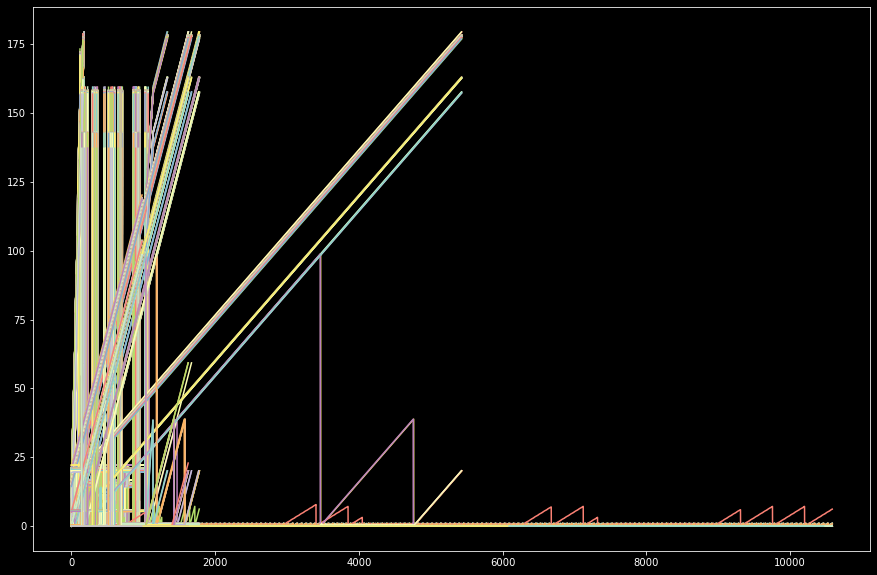

In [8]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

for lat_stats in pub_cb_to_lat_stats.values():
    ax.plot(np.where(np.isnan(lat_stats.pub_use_latencies), 0, lat_stats.pub_use_latencies))

ax.set_ylim(4)